In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import time
from datetime import datetime

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV


# Best: 0.766234 using {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50} with auto-category by xgoost


In [44]:
dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']

cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type','sla']
numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']

colLabel='severity_label'

colFeatures=cateFeatures+numericFeatures
cols=[colLabel]+colFeatures
print(cols)

isAutomaticOneHotByColumnTransformer=True
isManualEncoding=False
 
to_date='2023-12-31'

xscore='accuracy'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla', 'count_detail', 'open_to_close_hour', 'response_to_resolved_hour', 'open_to_response_hour', 'resolved_to_close_hour']


# Load and Prepare Data

In [31]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
df_incident=df_incident.query("open_datetime<=@to_date")
df_incident=df_incident[cols]
print(df_incident.info())
df_incident.tail()



Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_label             2096 non-null   object 
 1   product_type               2096 non-null   object 
 2   brand                      2096 non-null   object 
 3   incident_type              2096 non-null   object 
 4   service_type               2096 non-null   object 
 5   is_failure_type            2096 non-null   bool   
 6   sla                        2096 non-null   object 
 7   count_detail               2096 non-null   int64  
 8   open_to_close_hour         2095 non-null   float64
 9   response_to_resolved_hour  2095 non-null   float64
 10  open_to_response_hour      2096 non-null   float64
 11  resolved_to_close_hour     2094 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(6)
mem

,severity_label,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2091,Minor,Storage,YIP,General Incident,Request,False,24x7 6Hrs Resolution Time,1,67.250000,0.000000,67.250000,0.000000
2092,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667,169.016667,2.633333,193.666667
2093,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667,4.533333,0.550000,15.083333
2094,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333,0.000000,23.783333,0.000000
2095,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000,28.466667,1.450000,1.233333


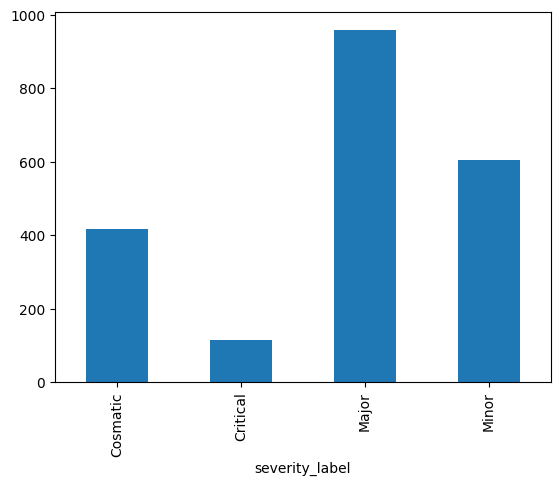

In [32]:
df_incident.groupby([colLabel]).size().plot(kind='bar')
plt.show()

# Process features and class

In [33]:
# cate_features=[ col for col in features if  col not in numericFeatures ]
if isAutomaticOneHotByColumnTransformer==False:
    
    if isManualEncoding==False:
        print("Let XGBoost encode itself")
    else:
        print("Encode by  LabelEncoder")
    features=[ col for col in list(df_incident.columns) if  col!=colLabel ]
    X = df_incident.loc[:,features]
    for cate_col in cateFeatures:
        if isManualEncoding==False:
              X[cate_col]=X[cate_col].astype("category")             
        else:  
            cateFeatEncoder = LabelEncoder()
            X[cate_col]=cateFeatEncoder.fit_transform(X[cate_col])

else:
        categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ct = ColumnTransformer(transformers=[("cat", categorical_transformer,cateFeatures )],remainder='passthrough')
        ct.set_output(transform='pandas')
        X = ct.fit_transform(df_incident)
        colLabel=f"remainder__{colLabel}"
        print(f"{colLabel} :OneHot Encoding to Fetures by ColumnTransformer")
        
        



remainder__severity_label :OneHot Encoding to Fetures by ColumnTransformer


In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   cat__product_type_Access Point              2096 non-null   float64
 1   cat__product_type_Firewall                  2096 non-null   float64
 2   cat__product_type_Hardware                  2096 non-null   float64
 3   cat__product_type_Other                     2096 non-null   float64
 4   cat__product_type_Security                  2096 non-null   float64
 5   cat__product_type_Server                    2096 non-null   float64
 6   cat__product_type_Software                  2096 non-null   float64
 7   cat__product_type_Storage                   2096 non-null   float64
 8   cat__product_type_Switch                    2096 non-null   float64
 9   cat__product_type_Tape Library              2096 non-null   float64
 10  cat__brand_B

In [35]:
if isAutomaticOneHotByColumnTransformer==False:
    Y = df_incident.loc[:,[colLabel]]
    Y[colLabel]=Y[colLabel].astype("category")

    
else:
    Y=X.pop(colLabel)
    # # X=X.pop(colLabel)
    # Y[colLabel]=Y[colLabel].astype("category")

    print(Y.info())
Y[:5]

<class 'pandas.core.series.Series'>
Int64Index: 2096 entries, 0 to 2095
Series name: remainder__severity_label
Non-Null Count  Dtype 
--------------  ----- 
2096 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB
None


0    Major
1    Major
2    Major
3    Minor
4    Major
Name: remainder__severity_label, dtype: object

In [36]:
print(X.info())
X.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   cat__product_type_Access Point              2096 non-null   float64
 1   cat__product_type_Firewall                  2096 non-null   float64
 2   cat__product_type_Hardware                  2096 non-null   float64
 3   cat__product_type_Other                     2096 non-null   float64
 4   cat__product_type_Security                  2096 non-null   float64
 5   cat__product_type_Server                    2096 non-null   float64
 6   cat__product_type_Software                  2096 non-null   float64
 7   cat__product_type_Storage                   2096 non-null   float64
 8   cat__product_type_Switch                    2096 non-null   float64
 9   cat__product_type_Tape Library              2096 non-null   float64
 10  cat__brand_B

,cat__product_type_Access Point,cat__product_type_Firewall,cat__product_type_Hardware,cat__product_type_Other,cat__product_type_Security,cat__product_type_Server,cat__product_type_Software,cat__product_type_Storage,cat__product_type_Switch,cat__product_type_Tape Library,...,cat__sla_24x7 4Hrs Response Time,cat__sla_24x7 6Hrs Resolution Time,cat__sla_24x7 6Hrs Response Time,cat__sla_8x5 4Hrs Response Time,cat__sla_9x5xNBD 4Hrs Response Time,remainder__count_detail,remainder__open_to_close_hour,remainder__response_to_resolved_hour,remainder__open_to_response_hour,remainder__resolved_to_close_hour
2091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,67.250000,0.000000,67.250000,0.000000
2092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,3,365.316667,169.016667,2.633333,193.666667
2093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2,20.166667,4.533333,0.550000,15.083333
2094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,23.783333,0.000000,23.783333,0.000000
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2,31.150000,28.466667,1.450000,1.233333


# Encode string class values as integers

In [37]:
label_encoder = LabelEncoder()
ylabelEncoded = label_encoder.fit_transform(Y)

print(label_encoder.classes_)

print(ylabelEncoded[-5:])

['Cosmatic' 'Critical' 'Major' 'Minor']
[3 2 2 2 2]


# XGBoost Fit model

In [38]:
# # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
# if isManualEncoding==True or isAutomaticOneHotByColumnTransformer==True:
#     print("XGBClassifier()")
#     model = XGBClassifier()
# else:
#    print("XGBClassifier(enable_categorical=True,tree_method=hist)")
#    model = XGBClassifier(enable_categorical=True,tree_method="hist")

# print(model)

# n_estimators = list(range(10, 30,10))
# learning_rate=[0.001,0.01]
# n_estimators = list(range(50,500 ,50))
# learning_rate =[0.001,0.005,0.01,0.05,0.1,0.5]
# max_depth = [6, 10, 15, 20]

# print('the number of trees: ',n_estimators)
# print('learning rate: ',learning_rate)
# print('max_depth: ',max_depth)

# print(f"Tune combination : {len(n_estimators)*len(learning_rate)*len(max_depth)}")
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=max_depth)

# Random Forst fit Model

In [39]:
model=RandomForestClassifier(random_state=42)
n_estimators = list(range(50,500 ,50))
max_features =['auto', 'sqrt', 'log2']
max_depth = [6, 10, 15, 20]

print('the number of trees: ',n_estimators)
print('max_features: ',max_features)
print('max_depth: ',max_depth)

print(f"Tune combination : {len(n_estimators)*len(max_features)*len(max_depth)}")
param_grid = dict(max_features=max_features, n_estimators=n_estimators,max_depth=max_depth)


the number of trees:  [50, 100, 150, 200, 250, 300, 350, 400, 450]
max_features:  ['auto', 'sqrt', 'log2']
max_depth:  [6, 10, 15, 20]
Tune combination : 108


In [40]:
# tune parameter
xsplits=10
kfold = StratifiedKFold(n_splits=xsplits, shuffle=True, random_state=7)


In [41]:
t_Start=time.time()

print(f"Start tuning at {datetime.now()}")

Start tuning at 2023-02-09 17:02:35.423605


In [43]:
# grid search

grid_search = GridSearchCV(model, param_grid, scoring=xscore, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, ylabelEncoded)

In [ ]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


In [109]:
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators),len(max_depth))
scores

array([[[0.72470039, 0.73041695, 0.7308977 , 0.73901572],
        [0.73710412, 0.73566644, 0.73757348, 0.73853497],
        [0.73614719, 0.73092732, 0.73330599, 0.73521075],
        [0.73568239, 0.73663477, 0.7342447 , 0.73519936],
        [0.73710412, 0.7399681 , 0.73521075, 0.73759171],
        [0.73855548, 0.74332422, 0.74617681, 0.74568922],
        [0.74616541, 0.74807245, 0.74330371, 0.73616541],
        [0.73759398, 0.73998633, 0.74380041, 0.74855776],
        [0.74473684, 0.7466416 , 0.74711552, 0.74425154]],

       [[0.73710412, 0.73853042, 0.73758715, 0.7409296 ],
        [0.74235817, 0.74378446, 0.75141262, 0.75332194],
        [0.75475735, 0.73663477, 0.74140123, 0.74236045],
        [0.74522898, 0.74952381, 0.7547733 , 0.7562087 ],
        [0.75907496, 0.75860105, 0.74760766, 0.74330599],
        [0.74569834, 0.74951925, 0.75716108, 0.7571702 ],
        [0.75859877, 0.75669856, 0.75860105, 0.746653  ],
        [0.74520848, 0.74378902, 0.75142401, 0.75475735],
        [0.7

In [63]:
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='lr: ' + str(value))

# plt.legend()
# plt.xlabel('n_estimators')
# plt.ylabel(xscore.title())
# #plt.savefig('n_estimators-vs-learning_rate.png')
# plt.show()